In [175]:
import pandas as pd
import pandas as pd
import numpy as np
taille = pd.read_csv('C:/Users/Administrateur/Desktop/HydroClad/data_correction/Cpta_23-10-18_17.18_1.csv', sep=';')
inter = pd.read_csv('C:/Users/Administrateur/Desktop/HydroClad/data_correction/Synthese_correction_ficelle_Taillees.csv', sep=';')
taille_merge = taille[['datetime', 'Dep25_Ce', 'Patm']]
taille_merge.loc[:, 'datetime'] = pd.to_datetime(taille_merge['datetime'], format='%d/%m/%Y %H:%M')
inter['Date intervention']= pd.to_datetime(inter['Date intervention'], format='%d/%m/%Y %H:%M')

In [176]:
#reset index
inter = inter.sort_values(by='Date intervention')
taille_merge = taille_merge.sort_values(by='datetime')

inter.reset_index(drop=True, inplace=True)
taille_merge.reset_index(drop=True, inplace=True)

In [177]:
# Constantes
altitude = 213.5604
hauteur_tube = 0.36
hauteur_sonde = 0.63

In [178]:
# Ajout des colonnes
taille_merge['Patm0'] = 0
taille_merge['ngf_nappe'] = 0
taille_merge['Dep25_corr'] = 0
taille_merge['Longueur de ficelle'] = 0

In [179]:
# Correction atmosphérique et mise à jour de Patm0
for i in range(len(inter)):
    # Si l'étalonnage P est "oui", mettre à jour la dernière valeur de Patm
    if inter.loc[i, 'etalonnage P'] == 'oui':
        # Sélection de la période entre la date d'intervention actuelle et la suivante
        periode = (taille_merge['datetime'] >= inter.loc[i, 'Date intervention']) & ((taille_merge['datetime'] < inter.loc[i + 1, 'Date intervention']) if i + 1 < len(inter) else (taille_merge['datetime'] < pd.to_datetime('now')))
        
        # Vérifier si la sélection renvoie au moins une ligne
        if not taille_merge.loc[periode].empty:
            # Si la sélection renvoie une ligne, prendre la Patm la plus proche
            Patm0 = taille_merge.loc[periode, 'Patm'].iat[0]
    
        # Mise à jour de la colonne 'Patm0' dans le DataFrame "taille_merge"
        taille_merge.loc[periode, 'Patm0'] = Patm0
       
    # Si l'étalonnage P est "non" et qu'il y a une valeur précédente de 'Patm0', la conserver
    elif Patm0 != 0:
        periode = (taille_merge['datetime'] >= inter.loc[i, 'Date intervention']) & ((taille_merge['datetime'] < inter.loc[i + 1, 'Date intervention']) if i + 1 < len(inter) else (taille_merge['datetime'] < pd.to_datetime('now')))
        taille_merge.loc[periode, 'Patm0'] = Patm0


In [180]:
# Mise à jour de la colonne 'Dep25_corr' en fonction de Dep25_Ce, Patm et Patm0
taille_merge['Dep25_corr'] = taille_merge['Dep25_Ce'] + (taille_merge['Patm'] - taille_merge['Patm0']) / 100


In [181]:
# Mise à jour longeur de ficelle : 

for i in range(len(inter)):
    # Sélection de la période entre la date d'intervention actuelle et la suivante
    periode = (taille_merge['datetime'] >= inter.loc[i, 'Date intervention']) & (taille_merge['datetime'] < inter.loc[i + 1, 'Date intervention'] if i + 1 < len(inter) else True)
    
    # Mise à jour de la colonne 'Longueur de ficelle' pour la période sélectionnée
    taille_merge.loc[periode, 'Longueur de ficelle'] = inter.loc[i, 'Longueur de ficelle (m)']


In [185]:
# Calcul 'ngf_nappe'
taille_merge['ngf_nappe'] = altitude - taille_merge['Longueur de ficelle'] - hauteur_sonde + hauteur_tube + taille_merge['Dep25_corr']



In [183]:
# Supprimer les lignes où Dep25_Ce est égal à 0
taille_merge = taille_merge[taille_merge['Patm'] != 0]
taille_merge = taille_merge[taille_merge['Dep25_Ce'] != 0]


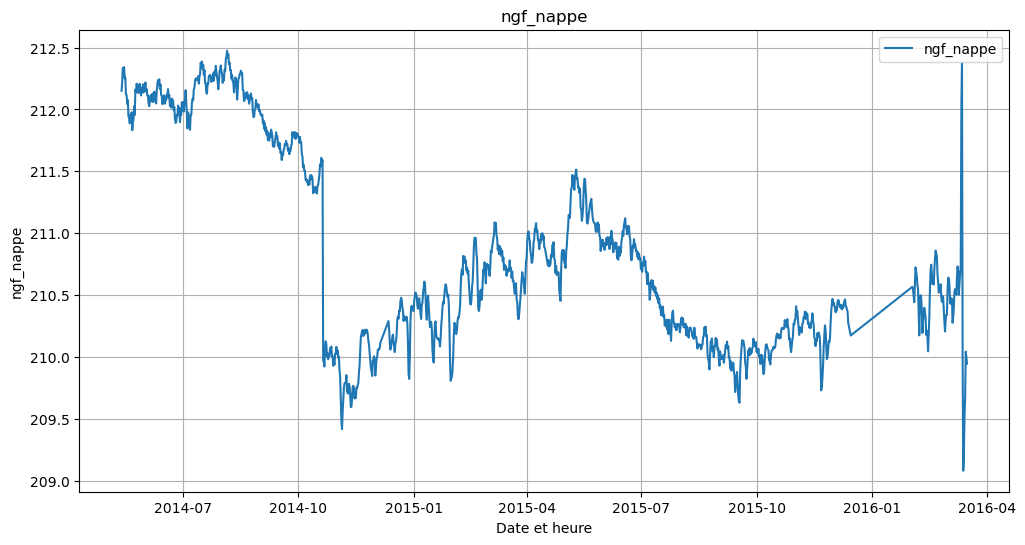

In [188]:
import matplotlib.pyplot as plt

# Assurez-vous que la colonne 'datetime' est de type datetime
taille_merge['datetime'] = pd.to_datetime(taille_merge['datetime'])

# Tracer le graphique
plt.figure(figsize=(12, 6))
plt.plot(taille_merge['datetime'], taille_merge['ngf_nappe'], label='ngf_nappe')
plt.title('ngf_nappe')
plt.xlabel('Date et heure')
plt.ylabel('ngf_nappe')
plt.legend()
plt.grid(True)
plt.show()

In [160]:
taille_merge.to_csv('C:/Users/Administrateur/Desktop/HydroClad/data_correction/taille_modifie2.csv', index=False)
